In [1]:
%matplotlib widget

import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from pymatreader import read_mat
from scipy import sparse
import numpy as np
import os
from datetime import datetime, timedelta
import pandas
import cv2
import json
import pandas as pd
from amftrack.pipeline.paths.directory import *
from amftrack.util.sys import *
import pickle
from joblib import Parallel, delayed
from datetime import datetime
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.post_processing.global_plate import *
from amftrack.pipeline.functions.post_processing.global_hypha import *
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.post_processing.time_plate import *

/home/cbisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory = directory_project
# update_analysis_info(directory)
analysis_info = get_analysis_info(directory)

In [3]:
select = analysis_info.loc[analysis_info['Plate']!=22]

In [3]:
select = analysis_info.loc[analysis_info['Plate']==102]

In [4]:
frames = []
for index, row in select.iterrows():
    if os.path.isfile(f'{directory}{row["path_global_hypha_info"]}'):
        frame = pd.read_json(f'{directory}{row["path_global_hypha_info"]}',convert_dates=True).transpose()
        frame.index.name = 'hypha'
        frame.reset_index(inplace=True)
        frames.append(frame)
global_hypha_info = pd.concat(frames,ignore_index=True)

In [7]:
global_hypha_info.loc[global_hypha_info['Plate'].isin([90])]

,hypha,out_of_ROI,av_width_final,tot_length_C,tot_growth_C,tot_length_pp,tot_growth_pp,timestep_stop_growth,time_stop_growth,time_init_growth,mean_speed,strop_track,timestep_anastomosis,timestep_biological_stop_growth,Plate,path_exp,folder_analysis,num_branch,timestep_init_growth
116574,1,None,22.9755,3876.11,12.1976,3728.9,32.8204,0,0,0,0,4,None,0,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
116575,27,None,22.9755,3871.73,0,3728.9,44.7836,0,0,0,0,4,None,0,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
116576,33,None,17.4143,2355.39,168.828,1999.38,163.875,1,4,0,42.2071,1,None,None,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
116577,37,None,13.2472,374.588,6.21958,325.079,32.2257,0,0,0,0,4,None,0,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
116578,99,None,16.1887,1033.58,317.039,969.052,309.545,14,56.1833,0,4.83592,40,None,14,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121117,97690,54,5.91357,436.517,0,312.496,0,54,216.4,216.4,0,54,None,None,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
121118,97763,54,3.78262,239.795,0,213.858,0,54,216.4,216.4,0,54,None,None,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
121119,97856,54,19.1733,273.521,0,255.073,0,54,216.4,216.4,0,54,None,None,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN
121120,97859,54,6.32731,694.746,0,650.91,0,54,216.4,216.4,0,54,None,None,90,Analysis_1645714372131513138_0_55_Version11/ex...,Analysis_1645714372131513138_0_55_Version11,NaN,NaN


In [6]:
path_save = f'/scratch-shared/amftrack/temp/global_hypha_infos.pick'
global_hypha_info.to_pickle(path_save)
dir_drop = 'data_tables'
API = str(np.load(os.getenv('HOME')+'/pycode/API_drop.npy'))
upload(API,path_save,f'/{dir_drop}/global_hypha_infos.pick',chunk_size=256 * 1024 * 1024)
path_save = f'/scratch-shared/amftrack/temp/global_hypha_infos.csv'
global_hypha_info.to_csv(path_save)
dir_drop = 'data_tables'
API = str(np.load(os.getenv('HOME')+'/pycode/API_drop.npy'))
upload(API,path_save,f'/{dir_drop}/global_hypha_infos.csv',chunk_size=256 * 1024 * 1024)

In [16]:
global_hypha_info = global_hypha_info.replace({None: -1})

In [17]:
global_hypha_info['log_tot_growth_C'] = np.log((global_hypha_info['tot_growth_C']+1.0).astype(float))
global_hypha_info['Plate_label'] = global_hypha_info['Plate'].astype(str)
global_hypha_info['branch_frequ'] = global_hypha_info['num_branch']/global_hypha_info['tot_growth_C']

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
select = global_hypha_info.loc[global_hypha_info['mean_speed'].between(5,400)&global_hypha_info['av_width_final'].between(1,15)&(global_hypha_info['Plate'].isin([799,94,800]))]
select = select.loc[select['branch_frequ'].between(0.0001,0.01)]

array([[<AxesSubplot:title={'center':'10'}>,
        <AxesSubplot:title={'center':'26'}>,
        <AxesSubplot:title={'center':'76'}>,
        <AxesSubplot:title={'center':'80'}>],
       [<AxesSubplot:title={'center':'88'}>,
        <AxesSubplot:title={'center':'91'}>,
        <AxesSubplot:title={'center':'94'}>,
        <AxesSubplot:title={'center':'152'}>],
       [<AxesSubplot:title={'center':'785'}>,
        <AxesSubplot:title={'center':'787'}>,
        <AxesSubplot:title={'center':'790'}>,
        <AxesSubplot:title={'center':'792'}>],
       [<AxesSubplot:title={'center':'799'}>,
        <AxesSubplot:title={'center':'800'}>,
        <AxesSubplot:title={'center':'808'}>, <AxesSubplot:>]],
      dtype=object)

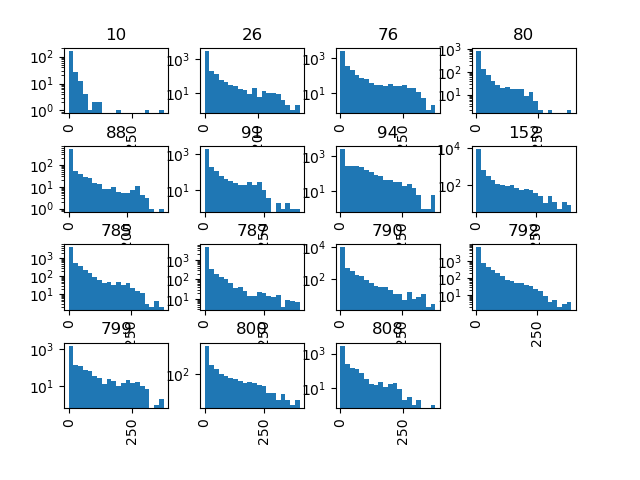

In [17]:
global_hypha_info.loc[global_hypha_info['mean_speed'].between(0,400)].hist('mean_speed',by = 'Plate',log = True, bins = 20)

In [88]:
select = global_hypha_info.loc[global_hypha_info['mean_speed'].between(5,400)&global_hypha_info['av_width_final'].between(1,15)&(global_hypha_info['Plate'].isin([799,94,800]))]

In [84]:
select = global_hypha_info.loc[global_hypha_info['mean_speed'].between(5,400)&global_hypha_info['av_width_final'].between(1,15)]

In [81]:
select

,hypha,av_width_final,tot_length_C,tot_growth_C,Plate,path_exp,folder_analysis,timestep_anastomosis,tot_length_pp,tot_growth_pp,timestep_stop_growth,time_stop_growth,time_init_growth,mean_speed,strop_track,timestep_biological_stop_growth,log_tot_growth_C,Plate_label
0,0,8.96476,12773.1,10150.7,799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,62,11422.9,9096.43,63,166,0,61.1485,63,None,9.225392,799
1,1,6.35393,639.454,465.91,799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,None,626.84,456.196,3,6,0,75.1353,4,3,6.146135,799
5,22,8.601,5370.08,1615.28,799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,None,4914.7,1551.47,44,101.467,0,15.9409,45,44,7.387885,799
8,40,7.75922,5948.74,1026.18,799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,None,5901.52,1014.2,4,8,2,171.03,4,None,6.934572,799
9,41,5.89912,245.992,87.1147,799,Analysis_1636046826216022929_0_100_Version9/ex...,Analysis_1636046826216022929_0_100_Version9,None,241.777,90.2951,2,4,2,42.3934,4,2,4.478639,799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31755,126400,4.62953,2094.94,397.875,94,Analysis_1636046622780809853_0_100_Version9/ex...,Analysis_1636046622780809853_0_100_Version9,None,2066.67,388.221,99,99.3333,98.25,367.269,99,None,5.988647,94
31761,126529,6.3769,260.681,66.3436,94,Analysis_1636046622780809853_0_100_Version9/ex...,Analysis_1636046622780809853_0_100_Version9,None,255.003,63.6149,99,99.3333,98.25,61.2402,99,None,4.209807,94
31763,126658,8.7426,3755.63,350.481,94,Analysis_1636046622780809853_0_100_Version9/ex...,Analysis_1636046622780809853_0_100_Version9,None,3546.32,1214.07,99,99.3333,98.25,323.521,99,None,5.862155,94
31774,126715,9.87582,35727.6,173.365,94,Analysis_1636046622780809853_0_100_Version9/ex...,Analysis_1636046622780809853_0_100_Version9,None,34125.2,172.578,99,99.3333,98.25,160.029,99,None,5.161150,94


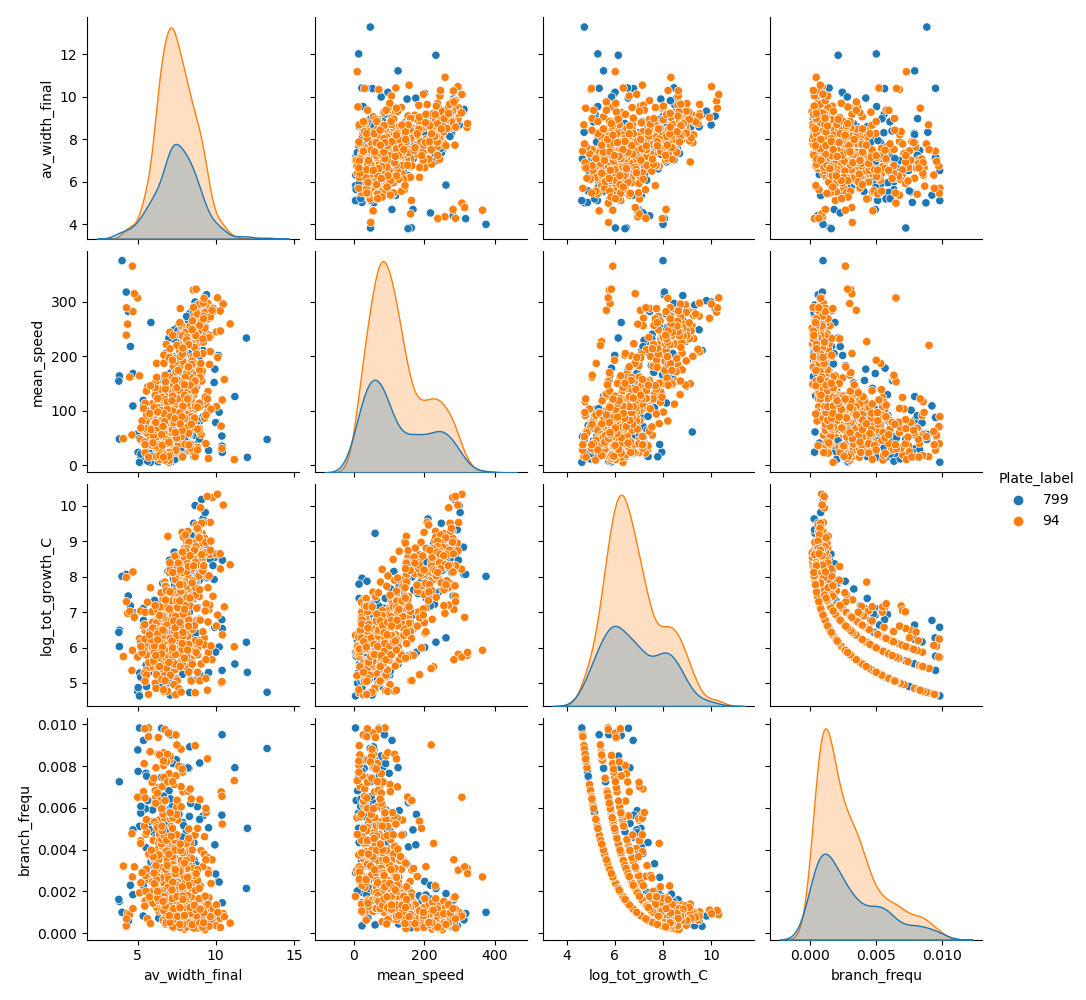

In [25]:
plt.close('all')
import seaborn as sns
sns.pairplot(select,vars = ['av_width_final','mean_speed','log_tot_growth_C','branch_frequ'],kind = "scatter", hue = 'Plate_label')

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/seaborn/axisgrid.py:1242: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


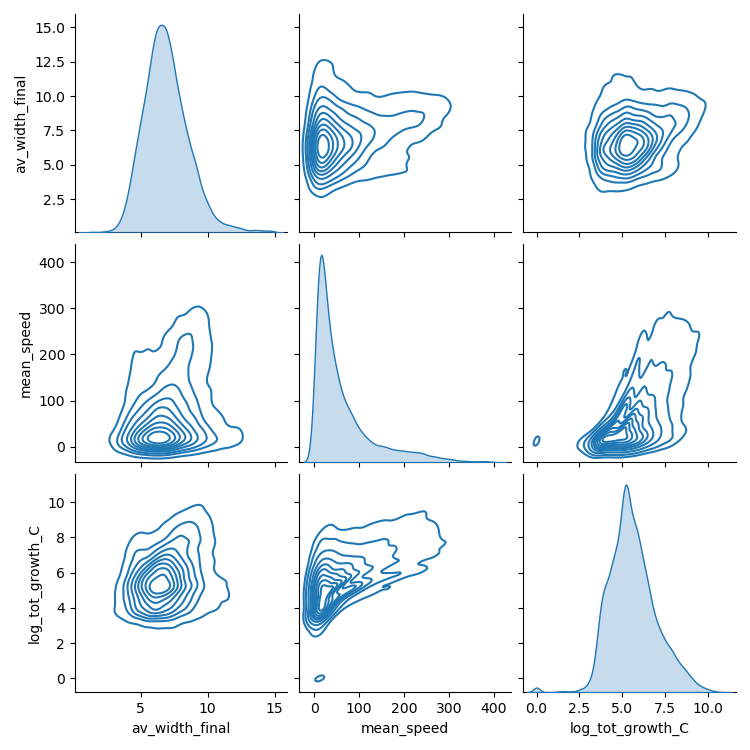

In [86]:
sns.pairplot(select,vars = ['av_width_final','mean_speed','log_tot_growth_C'],kind = "kde")